In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import rasterio
import rasterio.mask
from shapely.geometry import box

In [3]:
import cv2
cv2.__version__

'4.1.1'

# Constants

In [4]:
DATA_DIR = "../data/raw/"
DATAFRAMES_DIR = "../data/processed/"

train_dataframes = glob(DATAFRAMES_DIR + "/train/*.pkl", recursive=True)
validate_dataframes = glob(DATAFRAMES_DIR + "/validate/*.pkl", recursive=True)
images = glob(DATA_DIR + "**/**/*.tif", recursive=True)
zone_to_image = {p.split("/")[-2]:p for p in images}

# Read data

In [101]:
trainset = {}
for d in train_dataframes:
    df = pd.read_pickle(d).reset_index(drop=True)
    df = df.to_crs(df.at[0, "crs"]).drop(columns="crs")
    trainset[df.at[0, "zone"]] = df

valset = {}
for d in validate_dataframes:
    df = pd.read_pickle(d).reset_index(drop=True)
    df = df.to_crs(df.at[0, "crs"]).drop(columns="crs")
    valset[df.at[0, "zone"]] = df

In [102]:
logging.info(f"trainset: {', '.join(list(trainset.keys()))}")        
logging.info(f"valset: {', '.join(list(valset.keys()))}") 

INFO:root:trainset: borde_soacha, castries, mixco_3, borde_rural, dennery, gros_islet, mixco_1_and_ebenezer
INFO:root:valset: dennery, borde_soacha, mixco_1_and_ebenezer, mixco_3, gros_islet, castries, borde_rural


In [103]:
zone_to_image

{'gros_islet': 'stac/st_lucia/gros_islet/gros_islet_ortho-cog.tif',
 'castries': 'stac/st_lucia/castries/castries_ortho-cog.tif',
 'dennery': 'stac/st_lucia/dennery/dennery_ortho-cog.tif',
 'mixco_3': 'stac/guatemala/mixco_3/mixco_3_ortho-cog.tif',
 'mixco_1_and_ebenezer': 'stac/guatemala/mixco_1_and_ebenezer/mixco_1_and_ebenezer_ortho-cog.tif',
 'borde_rural': 'stac/colombia/borde_rural/borde_rural_ortho-cog.tif',
 'borde_soacha': 'stac/colombia/borde_soacha/borde_soacha_ortho-cog.tif'}

In [104]:
trainset["mixco_1_and_ebenezer"].crs

'+init=epsg:32616'

# Playground

In [105]:
row = trainset["gros_islet"].iloc[345]

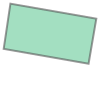

In [106]:
row.geometry

In [107]:
raster = rasterio.open(zone_to_image["gros_islet"])
out_img, out_transform = rasterio.mask.mask(dataset=raster,
                                            shapes=[row.geometry], 
                                            crop=True)
out_img = np.transpose(out_img, [1, 2, 0])
mask = out_img[..., -1]

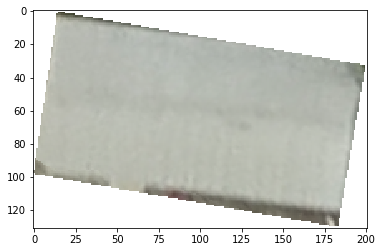

In [108]:
plt.imshow(out_img)

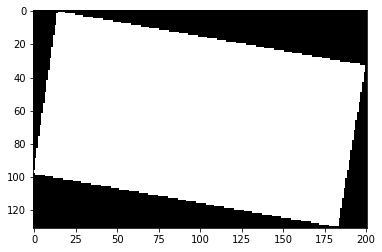

In [109]:
plt.imshow(mask, cmap="gray")

In [110]:
contours, ret = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
center, _, angle = cv2.minAreaRect(contours[0])
rot = cv2.getRotationMatrix2D(center, angle-90, 1)
new_shape = tuple((np.asarray(out_img.shape[:2])*2).tolist())
img = cv2.warpAffine(out_img[..., :3], rot, new_shape)
mask = cv2.warpAffine(mask, rot, new_shape) 
# Crop image
thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
# Find contour and sort by contour area
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(cnts[0])
crop = img[y:y+h, x:x+w].copy()
h, w, _ = crop.shape
if h > w:
    crop = np.transpose(crop, [1, 0, 2])

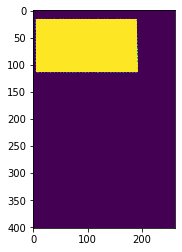

In [111]:
plt.imshow(mask)

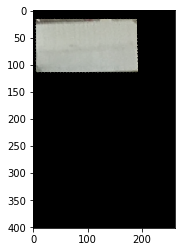

In [112]:
plt.imshow(img)

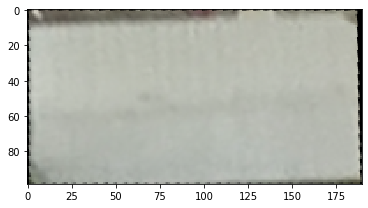

In [113]:
plt.imshow(crop)

In [114]:
abs(raster.meta["transform"].e)

0.036210000000000006

# Data generator

In [115]:
import logging
logging.getLogger().setLevel(logging.INFO)
from keras_preprocessing.image.iterator import Iterator

In [116]:
class CaribbeanDataset(Iterator):
    """
    """
    augmentation_params = {"buffer_jitter":(-1.5, 1.5), 
                           "angle_jitter":(-10, 10)}
    def __init__(self, 
                 dataframes,
                 zone_to_image, 
                 id_col=None,
                 label_col=None, 
                 batch_size=1,
                 crop_buffer=0.5,
                 shuffle=True,
                 augment=False,
                 seed=0,                 
                 image_preprocessing=None,
                 label_preprocessing=None,
                 *args,
                 **kwargs):
        """
        Creates a Keras dataset iterator from GeoDataFrames and raster images.
        Args:
            dataframes: list of GeoDataFrames which may have different crs.
            zone_to_image: dictionary that maps the DataFrame zone into a raster path.
            crop_buffer: buffer object crop a little bit (float wtih meter units).
            id_col (optional): specifies which DataFrame column use as example id.
            label_col (optional): specifies which DataFrame column use as label.
        """
        # Create offsets from dataframes lengths
        self._offsets = np.cumsum([0] + [len(df) for df in dataframes[:-1]])
        # Store dataframes with index continuity from one another
        self._dataframes = []
        for offset, df in zip(self._offsets, dataframes):
            df = df.reset_index(drop=True)
            df.index = df.index + offset 
            self._dataframes.append(df)
        # Dictionary that maps zone into raster paths        
        self._zone_to_image = zone_to_image   
        self._num_examples = sum([len(df) for df in self._dataframes])
        self._label_col = label_col
        self._id_col = id_col
        self._crop_buffer = crop_buffer
        self._augment = augment
        # Preprocessing image function
        self.image_preprocessing = image_preprocessing
        self.label_preprocessing = label_preprocessing
        # Init ImageDataGenerator
        super().__init__(n=self.__len__(),
                         batch_size=batch_size,
                         shuffle=shuffle,
                         seed=seed,
                         *args,
                         **kwargs)
            
    def _get_dataframe(self, idx):
        dataframe_idx = -1
        for j, offset in enumerate(self._offsets[1:]):
            if idx < offset:
                dataframe_idx = j
                break
        return self._dataframes[dataframe_idx]
    
    def _pad_and_stack(self, arrays, stack_axis=0):
        """Pad and stack a list of arrays."""
        shape_list = [arr.shape for arr in arrays]
        shapes = np.stack(shape_list, -1)
        max_shape = np.max(shapes, axis=-1)
        output_array = []
        for shape, arr in zip(shape_list, arrays):
            # Pad tensor
            paddings = np.stack([np.zeros_like(shape), max_shape - shape], axis=-1).tolist()
            if len(paddings)>0:
                output_array += [np.pad(arr, paddings, mode='constant')]
            else:
                output_array += [arr]
        return np.stack(output_array, stack_axis)
    
    def _get_batches_of_transformed_samples(self, idxs):
        """
        Get batch of samples.
        """
        # Create list of tuples [(id, img, label), (id, img, label)...]
        list_of_tuples = [self._get_sample(idx) for idx in idxs]
        # Create batch by transposing list of tuples into list of lists
        example_ids, batch_X, batch_Y = [list(tuples) for tuples in zip(*list_of_tuples)]
        # Stack lists into numpy arrays
        example_ids = np.asarray(example_ids)
        batch_Y = np.asarray(batch_Y)
        # Pad and stack images
        #batch_X = self._pad_and_stack(batch_X)
        batch_X = np.stack(batch_X, axis=0)
        return example_ids, batch_X, batch_Y
    
    def _get_sample(self, idx):
        """
        Wrapper around ___get_sample__.
        """
        try:
            return self.___get_sample__(idx)
        except:
            logging.error(f"Error processing sample {idx}")
            logging.error(self._get_dataframe(idx).loc[idx, :])
            raise
        
    def ___get_sample__(self, idx):
        """
        """
        # Retrieve dataframe row for idx
        row = self._get_dataframe(idx).loc[idx, :]      
        # Get shapely geometry from row
        geom = row.geometry
        if self._crop_buffer > 0:
            geom = geom.buffer(self._crop_buffer)
        if self._augment:
            aug_buffer = np.random.uniform(*self.augmentation_params["buffer_jitter"])
            geom = geom.buffer(aug_buffer)
        # Load image data 
        raster = rasterio.open(self._zone_to_image[row["zone"]])
        out_img, out_transform = rasterio.mask.mask(dataset=raster,
                                                    shapes=[geom], 
                                                    crop=True)
        out_img = np.transpose(out_img, [1, 2, 0])
        mask = out_img[..., -1]
        # Crop and fix its rotation
        contours, ret = cv2.findContours(mask, 
                                         cv2.RETR_TREE,
                                         cv2.CHAIN_APPROX_SIMPLE)
        center, _, angle = cv2.minAreaRect(contours[0])
        if self._augment:
            angle_jitter = np.random.uniform(*self.augmentation_params["angle_jitter"])
            angle += angle_jitter
        rot = cv2.getRotationMatrix2D(center, angle-90, 1)
        new_shape = tuple([max(out_img.shape[:2])*2]*2)
        img = cv2.warpAffine(out_img[..., :3], rot, new_shape)
        mask = cv2.warpAffine(mask, rot, new_shape) 
        # Crop image
        thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
        # Find contour and sort by contour area
        cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(cnts[0])
        crop_img = img[y:y+h, x:x+w].copy()
        h, w, _ = crop_img.shape
        if h > w:
            crop_img = np.transpose(crop_img, [1, 0, 2])
        # Retrieve label
        if self._label_col is None:
            label = None
        else:
            label = row[self._label_col]
        # Retrieve id
        if self._id_col is None:
            example_id = None
        else:
            example_id = row[self._id_col]
        # Apply preprocessing function
        if self.image_preprocessing:
            crop_img = self.image_preprocessing(crop_img)
        if self.label_preprocessing:
            label = self.label_preprocessing(label)
        return example_id, crop_img, label
        
    def __len__(self):
        """
        """
        return self._num_examples

In [117]:
def resize_with_pad(img, height, width):
    """
    Re-adapted numpy/opencv code from original tensorflow function:
        https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad
    """
    f_target_height = float(height)
    f_target_width = float(width)
    i_height, i_width = img.shape[:2]
    f_height = float(i_height)
    f_width = float(i_width)
    # Find the ratio by which the image must be adjusted
    # to fit within the target
    ratio = max(f_width / f_target_width, f_height / f_target_height)
    resized_height_float = f_height / ratio
    resized_width_float = f_width / ratio
    resized_height = int(resized_height_float)
    resized_width = int(resized_width_float)
    padding_height = (f_target_height - resized_height_float) / 2
    padding_width = (f_target_width - resized_width_float) / 2
    f_padding_height = float(int(padding_height))
    f_padding_width = float(int(padding_width))
    p_height = max(0, int(f_padding_height))
    p_width = max(0, int(f_padding_width))
    # Resize first, then pad to meet requested dimensions
    resized = cv2.resize(img, (resized_width, resized_height))
    r_height, r_width = resized.shape[:2]
    paddings = [[p_height, height-r_height-p_height],
                [p_width, width-r_width-p_width],
                [0, 0]]
    padded = np.pad(resized, paddings, mode='constant')
    return padded     
    
image_preprocessing_fn = lambda x: resize_with_pad(x, 200, 350)

In [118]:
dataset = CaribbeanDataset(list(trainset.values()),
                           zone_to_image,
                           label_col="roof_material",
                           id_col="id",
                           batch_size=3,
                           #augment=True,
                           image_preprocessing = image_preprocessing_fn,
                           crop_buffer=1)

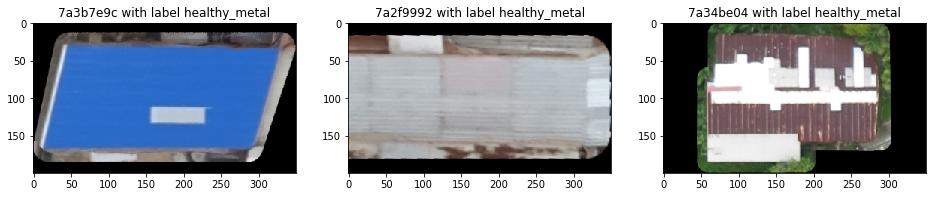

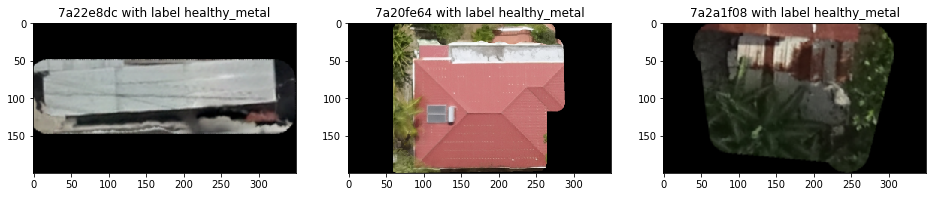

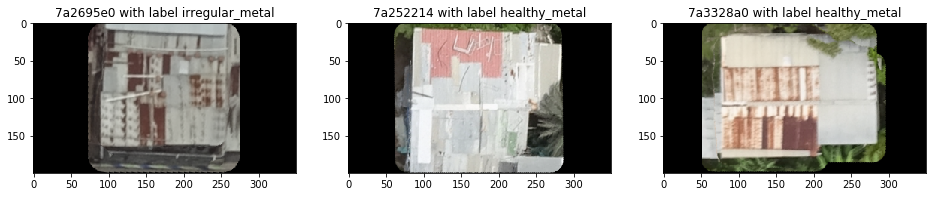

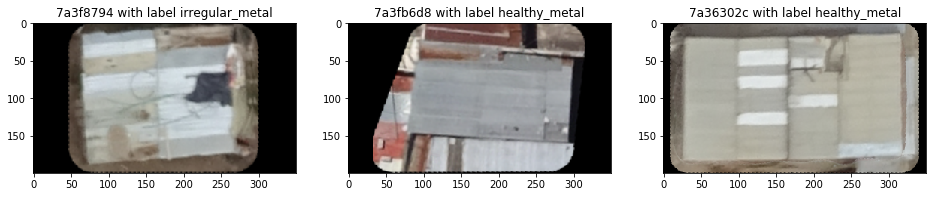

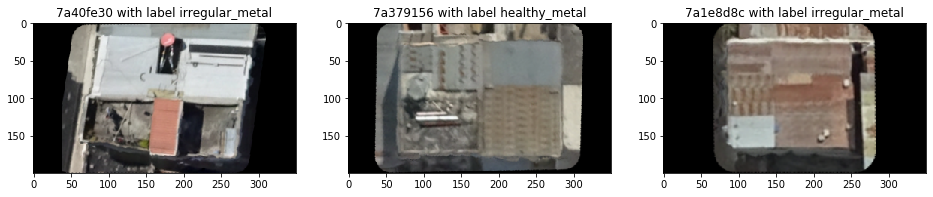

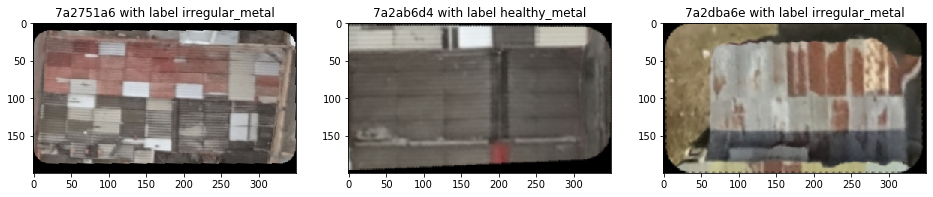

In [119]:
for example_ids, batch_X, batch_Y in dataset:
    try:
        fig, ax = plt.subplots(1, len(batch_Y), squeeze=False, figsize=(16, 9))
        for idx, (example_id, crop, label) in enumerate(zip(example_ids, batch_X, batch_Y)):
            ax[0, idx].imshow(crop)
            ax[0, idx].set_title(f"{example_id} with label {label}")
        plt.show()
    except KeyboardInterrupt:
        break

# Compute mean and std pixel

https://en.wikipedia.org/wiki/Moving_average

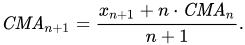

In [67]:
from tqdm import tqdm_notebook as tqdm

In [98]:
dataset = CaribbeanDataset(list(trainset.values()),
                           zone_to_image,
                           label_col="roof_material",
                           id_col="id",
                           batch_size=1, 
                           shuffle=False)

In [99]:
n = 0
cma = np.zeros([3])
cmvar =  np.zeros([3])
for idx, (_, batch_X, _) in tqdm(enumerate(dataset), total=dataset.n//dataset.batch_size):
    last_example_idx = (idx*dataset.batch_size) + dataset.batch_size
           
    flatten = np.reshape(batch_X, [-1, 3])
    mask =  np.where(np.any(flatten>0, axis=-1))[0]
    flatten = flatten.astype(np.float)
    n_pixels = len(mask)
    cma = (np.sum(flatten[mask, :], axis=0) + n*cma)/(n + n_pixels)
    cmvar = (np.var(flatten[mask, :], axis=0)*n_pixels + n*cmvar)/(n + n_pixels)
    n += n_pixels
    if last_example_idx >= dataset.n:
        break

In [100]:
logging.info(f"Mean pixel: {cma} and std pixel: {np.sqrt(cmvar)}")

INFO:root:Mean pixel: [158.79603792 152.8787508  145.85142704] and std pixel: [43.43501424 43.5819431  45.13825535]
